In [6384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import forestplot as fp
import missingno as msno
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
from statsmodels.formula.api import glm
from statsmodels.api import qqplot
from scipy.stats import ttest_ind as t_student
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kstest
from scipy.stats import norm
from matplotlib.patches import Rectangle

In [6385]:
# Chargement des données
effec1 = pd.read_csv("../csv/effec1.quest.compil.csv", encoding="ISO-8859-1")
effec2 = pd.read_csv("../csv/effec2.quest.compil.csv", encoding="ISO-8859-1")
effec3 = pd.read_csv("../csv/effec3.quest.compil.csv", encoding="ISO-8859-1")
#
usage1 = pd.read_csv("../csv/usages.effec1.csv", encoding="ISO-8859-1")
usage2 = pd.read_csv("../csv/usages.effec2.csv", encoding="ISO-8859-1")
usage3 = pd.read_csv("../csv/usages.effec3.csv", encoding="ISO-8859-1")

In [6386]:
usage1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7965 entries, 0 to 7964
Data columns (total 73 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Student_ID        7965 non-null   int64  
 1   Exam.score        20 non-null     float64
 2   Exam.bin          7965 non-null   int64  
 3   Assignment.score  2455 non-null   float64
 4   Assignment.bin    7965 non-null   int64  
 5   Quizz.1.score     4649 non-null   float64
 6   Quizz.1.bin       7965 non-null   int64  
 7   Quizz.2.score     3762 non-null   float64
 8   Quizz.2.bin       7965 non-null   int64  
 9   Quizz.3.score     3304 non-null   float64
 10  Quizz.3.bin       7965 non-null   int64  
 11  Quizz.4.bin       7965 non-null   int64  
 12  Quizz.4.score     2971 non-null   float64
 13  Quizz.5.bin       7965 non-null   int64  
 14  Quizz.5.score     2853 non-null   float64
 15  Intro.MOOC        0 non-null      float64
 16  Prez.sem.1        7965 non-null   int64  


In [6387]:
effec1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8986 entries, 0 to 8985
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Student_ID        8986 non-null   int64  
 1   Gender            5342 non-null   object 
 2   birth.year        5107 non-null   float64
 3   Country           5303 non-null   object 
 4   Diploma           5328 non-null   object 
 5   Formation         5306 non-null   object 
 6   CSP               5320 non-null   object 
 7   How.heard         5326 non-null   object 
 8   Exp.crea          5336 non-null   object 
 9   Curiosity.MOOC    5310 non-null   float64
 10  Certif.self.sat   5290 non-null   float64
 11  Rencontres        5287 non-null   float64
 12  Certif.work       5265 non-null   float64
 13  Incitation        5268 non-null   float64
 14  Temps.Dispo       5315 non-null   object 
 15  Exp.MOOC          5302 non-null   object 
 16  Completion.proba  5324 non-null   float64


In [6388]:
# Fusion des tables effec[n] et usage[n] dans des bases intermédiaires selon les identifiants des étudiants
bases_inter = []
for tabs in [(effec1, usage1), (effec2, usage2), (effec3, usage3)]:
    bases_inter.append(tabs[0].merge(tabs[1], on="Student_ID"))

In [6389]:
# Concaténation des tables intermédiaires afin de créer une seule base commune
base = pd.concat(bases_inter, join="outer", 
                 axis=0, ignore_index=False, 
                 keys=[1, 2, 3])

In [6390]:
base = base.reset_index(level=0).rename({"level_0": "Itération"}, axis=1)

In [6391]:
# Indication de non passage de la certification pour les itération 1 et 2 où seul l'examen existe.
base[["Exam.bin", "Certif.bin"]] = base[["Exam.bin", "Certif.bin"]].fillna(0)

In [6392]:
base[["Certif.bin", "Exam.bin"]]

,Certif.bin,Exam.bin
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0
...,...,...
3510,0.0,0
3511,0.0,0
3512,0.0,0
3513,0.0,0


In [6393]:
base = base.astype({"Exam.bin": bool, "Certif.bin": bool, "Student_ID": int})

In [6394]:
base = base.copy()
# Map des modalités M et H de la variable Country_HDI
base["New_HDI"] = np.select([base["Country_HDI"] == "M", 
                             base["Country_HDI"] == "H"],
                            ["I", "I"], default=base["Country_HDI"])

In [6395]:
# Sélection des vidéos
df_video = base.set_index(["Itération", "Student_ID", 
                            "Gender", "New_HDI"]).loc[:, 'S1.L1':'S5.L5'].drop(["Prez.sem.2", "Prez.sem.3", 
                                                                                "Prez.sem.4", "Prez.sem.5"], axis=1)

In [6396]:
# Sélection des Quiz
df_quiz = base.set_index(["Itération", "Student_ID", 
                            "Gender", "New_HDI"]).loc[:, 'Quizz.1.bin':'Quizz.5.bin'].drop(["Quizz.2.score", 
                                                                                            "Quizz.3.score", 
                                                                                            "Quizz.4.score"], axis=1)

In [6397]:
# Sélection des passages des Examens, certifications et assignment
df_exam = base.set_index(["Itération", "Student_ID", 
                            "Gender", "New_HDI"])[["Exam.bin", "Certif.bin", "Assignment.bin"]]

In [6398]:
df_exam

Exam.bin  Certif.bin  Assignment.bin
Itération Student_ID Gender    New_HDI                                      
1         221        NaN       NaN         False       False               0
          19178      une femme TH          False       False               0
          1086       une femme TH          False       False               0
          1948       une femme TH          False       False               0
          16209      une femme B           False       False               0
...                                          ...         ...             ...
3         42092      un homme  B           False       False               1
          64673      NaN       NaN         False       False               0
          67894      NaN       NaN         False       False               0
          66874      NaN       NaN         False       False               0
          66492      NaN       NaN         False       False               0

[15182 rows x 3 columns]

In [6399]:
# Nombre de videos par apprenant pour l'ensemble du MOOC.
total_video = pd.DataFrame(df_video.sum(axis=1), columns=["video"])

# Nombre de questionnaires par apprenant pour l'ensemble du MOOC.
total_quiz = pd.DataFrame(df_quiz.sum(axis=1), columns=["quiz"])

In [6400]:
total_video.head()

video
Itération Student_ID Gender    New_HDI       
1         221        NaN       NaN          0
          19178      une femme TH           1
          1086       une femme TH          30
          1948       une femme TH           1
          16209      une femme B            0

In [6401]:
total_quiz.head()

quiz
Itération Student_ID Gender    New_HDI      
1         221        NaN       NaN         0
          19178      une femme TH          0
          1086       une femme TH          4
          1948       une femme TH          0
          16209      une femme B           5

In [6402]:
# Création de la table regroupant toutes la variables pour mesurer l'engagement de chaque apprenant
total_student = pd.concat([total_video, total_quiz, df_exam], axis=1)

In [6403]:
total_student.head()

video  quiz  Exam.bin  Certif.bin  \
Itération Student_ID Gender    New_HDI                                      
1         221        NaN       NaN          0     0     False       False   
          19178      une femme TH           1     0     False       False   
          1086       une femme TH          30     4     False       False   
          1948       une femme TH           1     0     False       False   
          16209      une femme B            0     5     False       False   

                                        Assignment.bin  
Itération Student_ID Gender    New_HDI                  
1         221        NaN       NaN                   0  
          19178      une femme TH                    0  
          1086       une femme TH                    0  
          1948       une femme TH                    0  
          16209      une femme B                     0

In [6404]:
# selection des types d'apprenant
def student_type(col):
    video, quiz, exam, certif, devoir = col
    if (exam >= 1 or certif >= 1):
        return "Completer"
    elif quiz > 0 and devoir > 0:
        return "Disengaging"
    elif video > 6:
        return "Auditing"
    else:
        return "Bystander"    

In [6405]:
total_student["Type"] = total_student.apply(student_type, axis=1)

In [6406]:
total_student.head()

video  quiz  Exam.bin  Certif.bin  \
Itération Student_ID Gender    New_HDI                                      
1         221        NaN       NaN          0     0     False       False   
          19178      une femme TH           1     0     False       False   
          1086       une femme TH          30     4     False       False   
          1948       une femme TH           1     0     False       False   
          16209      une femme B            0     5     False       False   

                                        Assignment.bin       Type  
Itération Student_ID Gender    New_HDI                             
1         221        NaN       NaN                   0  Bystander  
          19178      une femme TH                    0  Bystander  
          1086       une femme TH                    0   Auditing  
          1948       une femme TH                    0  Bystander  
          16209      une femme B                     0  Bystander

In [6407]:
student = total_student.reset_index()[["Student_ID", "Type", "Itération"]]

In [6408]:
# Calcul du nombre d'apprenants par type et par itération
df_type = student.groupby(["Itération", "Type"])[["Type"]].count().rename({'Type': 'total'}, axis=1)

In [6409]:
df_type

total
Itération Type              
1         Auditing      1207
          Bystander     4285
          Completer       20
          Disengaging   2453
2         Auditing       538
          Bystander     2168
          Completer      876
          Disengaging    120
3         Auditing       375
          Bystander     2238
          Completer      832
          Disengaging     70

In [6410]:
df_type.reset_index("Type", inplace=True)

In [6411]:
# Nombre total d'apprenants par itération
df_iter = df_type.groupby("Itération").sum()

In [6412]:
df_iter

,total
Itération,
1,7965
2,3702
3,3515


In [6413]:
total_iter = df_type.merge(df_iter, on="Itération", suffixes=["_type", "_iter"])

In [6414]:
total_iter

,Type,total_type,total_iter
Itération,,,
1,Auditing,1207,7965
1,Bystander,4285,7965
1,Completer,20,7965
1,Disengaging,2453,7965
2,Auditing,538,3702
2,Bystander,2168,3702
2,Completer,876,3702
2,Disengaging,120,3702
3,Auditing,375,3515


In [6415]:
# Proportion d'apprenants par types d'apprenants et par itération
total_iter["proportion/iter"] = round(total_iter["total_type"] / total_iter["total_iter"] * 100, 1)

In [6416]:
total_iter

,Type,total_type,total_iter,proportion/iter
Itération,,,,
1,Auditing,1207,7965,15.2
1,Bystander,4285,7965,53.8
1,Completer,20,7965,0.3
1,Disengaging,2453,7965,30.8
2,Auditing,538,3702,14.5
2,Bystander,2168,3702,58.6
2,Completer,876,3702,23.7
2,Disengaging,120,3702,3.2
3,Auditing,375,3515,10.7


In [6417]:
base["Genre"] = base["Gender"].map({"un homme": "Homme", "une femme": "Femme"})

In [6418]:
# Tableau de contingence (croisement des 2 variables catégorielles)
tab_obs = pd.crosstab(index=base["Genre"], columns=base["New_HDI"])

In [6419]:
tab_obs.rename(columns={"un homme": "H", "une femme": "F"}, inplace=True)

In [6420]:
tab_obs

New_HDI,B,I,TH
Genre,,,
Femme,147,233,2545
Homme,883,432,4711


In [6421]:
# Test d'indépendance (chi2)
chi2, p_value, degres_liberte, tableau_attendu = chi2_contingency(tab_obs)

In [6422]:
tableau_attendu

array([[ 336.58250475,  217.308122  , 2371.10937325],
       [ 693.41749525,  447.691878  , 4884.89062675]])

In [6423]:
chi2

179.2420322171424

In [6424]:
p_value

1.196980957821505e-39

La p value est < 5% indiquerait que l'index HDI serait significativement lié au genre puisqu'il y a moins de 5 % de chance que les 2 variables soient indépendantes.

In [6425]:
#residus = (tab_HDI_gender - tableau_attendu) / tableau_attendu
residus = tab_obs - tableau_attendu

In [6426]:
residus

New_HDI,B,I,TH
Genre,,,
Femme,-189.582505,15.691878,173.890627
Homme,189.582505,-15.691878,-173.890627


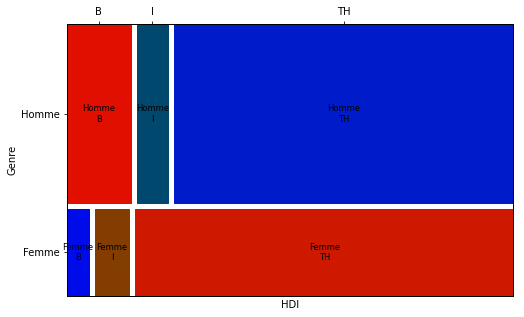

In [6427]:
# Mosaic du tableau de contingence
#props = lambda key: {'color': 'red' if residus(key[0]) > 0 else 'blue'},
fig, ax = plt.subplots(figsize=(8,5))
mosaic(tab_obs.stack(), statistic=True, gap=0.02, horizontal=False, ax=ax)
ax.set_xlabel("HDI")
ax.set_ylabel("Genre")
plt.savefig("../graph/mosaic_contingence.png")
plt.show()

In [6428]:
# valeurs attendues sous l'hypothèse nulle (H0).
x = tableau_attendu.flatten()

In [6429]:
x

array([ 336.58250475,  217.308122  , 2371.10937325,  693.41749525,
        447.691878  , 4884.89062675])

In [6430]:
# valeurs observées
y = tab_obs.stack().values

In [6431]:
y

array([ 147,  233, 2545,  883,  432, 4711])

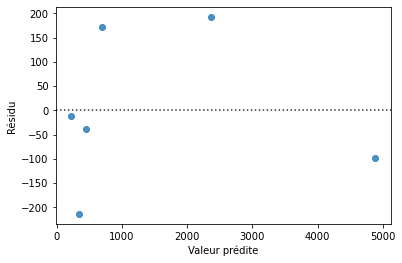

In [6432]:
# Résidus du modèle de prédiction
fig, ax = plt.subplots()
sns.residplot(x=x, y=y, ax=ax)
#ax.set_title("Résidus du modèle observé")
ax.set_ylabel("Résidu")
ax.set_xlabel("Valeur prédite")
plt.savefig("../graph/residus_chi2.png")
plt.show()

fig, ax = plt.subplots()
sns.heatmap(residus, annot=True, cmap='coolwarm', cbar=True, ax=ax)
ax.set_ylabel("Genre")
ax.set_ylabel("HDI")
plt.show()

formule du V de Cramer :

V = √(χ² / (n * (min(r, c) - 1)))

Dans cette formule :

V représente le coefficient de Cramer.
χ² est la statistique du chi carré.
n est la taille de l'échantillon.
r est le nombre de niveaux ou de catégories de la première variable.
c est le nombre de niveaux ou de catégories de la deuxième variable.

In [6433]:
# Fonction de calcul du V de Cramer
# data = tab ndarray
def V_Cramer(data):
    # somme de chaque colonne
    n = np.sum(data)
    # taille du tableau de contingence des variables catégorielles (taille de chaque échantillon pour chaque variable)
    row, col = tab_obs.shape
    # Formule du V de Cramer
    V = np.sqrt(chi2 / (n * (min([row, col]) - 1)))
    return V
    

In [6434]:
V_Cramer(np.array(tab_obs))

0.14150902903141144

In [6435]:
V_Cramer(tableau_attendu)

0.14150902903141144

La valeur V de Cramer étant faible il y a aurait une faible dépendance entre l'index HDI et le genre. Il y aurait donc statistiquement une association entre ses deux variables catégorielles, indiquée par la p-value du chi2, mais la valeur du V de Cramer indiquerait que cette dépendance serait faible. 

In [6436]:
# tableau du genre par étudiant
genre_etu = base[["Student_ID", "Genre"]].drop_duplicates(subset="Student_ID").dropna()

In [6437]:
genre_etu.head()

,Student_ID,Genre
1,19178,Femme
2,1086,Femme
3,1948,Femme
4,16209,Femme
5,6685,Homme


In [6438]:
# Nombre total de videos par étudiant
total_video_etu = total_video.groupby("Student_ID").sum()

In [6439]:
total_video_etu.head()

,video
Student_ID,
15,3
28,0
34,0
36,0
45,25


In [6440]:
# tableau du genre et du nombre total de videos visionnées par étudiant
etu_genre_video = total_video_etu.merge(genre_etu, on='Student_ID')

In [6441]:
etu_genre_video.head()

,Student_ID,video,Genre
0,45,25,Femme
1,83,22,Homme
2,84,8,Homme
3,87,1,Homme
4,94,2,Homme


In [6442]:
# moyenne du nombre de videos visionnées par genre
total_video_etu.merge(genre_etu, on="Student_ID").groupby("Genre")[["video"]].mean()

,video
Genre,
Femme,14.855376
Homme,13.867276


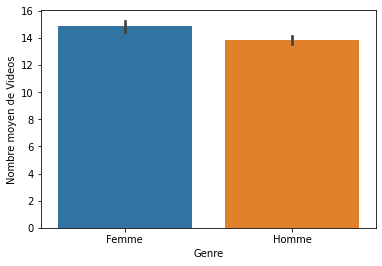

In [6443]:
# Figure de la distribution du nombre de video par rapport au genre 
fig, ax = plt.subplots()
sns.barplot(data=etu_genre_video, x="Genre", y="video", ax=ax)
ax.set_xlabel("Genre")
ax.set_ylabel("Nombre moyen de Videos")
plt.savefig("../graph/mean_video.png")
plt.show()

H0 (Hypothèse nulle) : il n'y a pas de différence sur le nombre de video visionnées entre les hommes et les femmes

In [6444]:
tab_stat = etu_genre_video.pivot_table(columns="Genre", index="Student_ID", values="video").fillna(0)

In [6445]:
tab_stat.head()

Genre,Femme,Homme
Student_ID,,
45,25.0,0.0
83,0.0,22.0
84,0.0,8.0
87,0.0,1.0
94,0.0,2.0


In [6446]:
# Test de Student
statistique, p_value = t_student(tab_stat["Homme"], tab_stat["Femme"])

In [6447]:
statistique

26.98492395204523

In [6448]:
p_value

3.4121378553908065e-157

Il y a moins de 5% de chance qu'il n'y ait pas de différence du nombre de visionnages entre les femmes et les hommes. Il y aurait significativement un lien entre le nombre de visionnages et le genre.

In [6449]:
# Sélection par genre
df_hom = etu_genre_video[etu_genre_video["Genre"] == "Homme"]
df_fem = etu_genre_video[etu_genre_video["Genre"] == "Femme"]

In [6450]:
df_hom

,Student_ID,video,Genre
1,83,22,Homme
2,84,8,Homme
3,87,1,Homme
4,94,2,Homme
5,98,23,Homme
...,...,...,...
8807,68205,30,Homme
8808,68220,30,Homme
8809,68223,0,Homme
8811,68265,14,Homme


In [6451]:
# Calcul des paramètres de la distribution normale pour chaque groupe
mu_hommes, std_hommes = np.mean(df_hom["video"]), np.std(df_hom["video"])
mu_femmes, std_femmes = np.mean(df_fem["video"]), np.std(df_fem["video"])

# Création des valeurs x pour tracer la courbe théorique
x_hommes = np.linspace(min(df_hom["video"]), max(df_hom["video"]), 100)
x_femmes = np.linspace(min(df_fem["video"]), max(df_fem["video"]), 100)

# Calcul des valeurs y correspondantes en utilisant la PDF de la distribution normale
y_hommes = norm.pdf(x_hommes, mu_hommes, std_hommes)
y_femmes = norm.pdf(x_femmes, mu_femmes, std_femmes)

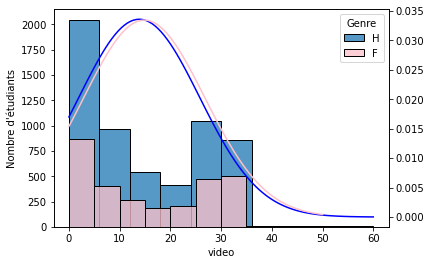

In [6452]:
figure, ax1 = plt.subplots()
sns.histplot(data=df_hom, x="video", bins=10, color="tab:blue", ax=ax1, label="H")
sns.histplot(data=df_fem, x="video", bins=10, color="pink", ax=ax1, label="F")
ax1.set_xlabel("video")
ax1.set_ylabel("Nombre d'étudiants")
ax1.legend(title="Genre")
ax2 = ax1.twinx()
ax2.plot(x_hommes, y_hommes, color='blue')
ax2.plot(x_femmes, y_femmes, color='pink')
plt.savefig("../graph/distribution_video.png")
plt.show()

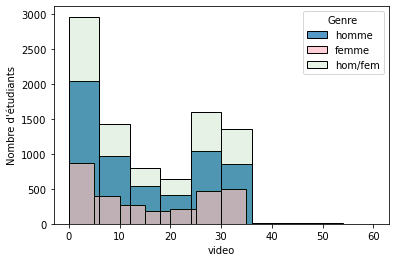

In [6453]:
# visualisation de la normalité de la distribution des données (histogramme de distribution)
figure, ax = plt.subplots()
sns.histplot(data=df_hom, x="video", bins=10, color="tab:blue", ax=ax, label="homme")
sns.histplot(data=df_fem, x="video", bins=10, color="pink", ax=ax, label="femme")
sns.histplot(data=etu_genre_video, x="video", bins=10, color="green", ax=ax, label="hom/fem", alpha=0.1)
ax.set_xlabel("video")
ax.set_ylabel("Nombre d'étudiants")
ax.legend(title="Genre")
plt.savefig("../graph/distribution_video2.png")
plt.show()

La distribution des données ne suit pas une loi normale. Ce qui ne permet pas de faire un test t-Student puisque la condition première est que les données doivent être normalement distribuées.

In [6454]:
# Models de regression du nombre de video selon le genre
mdl_video_vs_genre = ols("video ~ Genre", data=etu_genre_video).fit()

In [6455]:
mdl_video_vs_genre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  video   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.45
Date:                Tue, 27 Jun 2023   Prob (F-statistic):           0.000247
Time:                        19:35:55   Log-Likelihood:                -34348.
No. Observations:                8818   AIC:                         6.870e+04
Df Residuals:                    8816   BIC:                         6.871e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         14.8554      0.221     67.365      0.000      14.423      15.288
Genre[T.Homme]    -0.9881      0.269     -3.667      0.000      -1.516      -0.460
==============================================================================
Omnibus:                    59307.238   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              878.417
Skew:                           0.240   Prob(JB):                    1.80e-191
Kurtosis:                       1.530   Cond. No.                         3.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Le coefficient R² étant proche de 0, le model de régression est peu fidèle à l'observation des données. 

In [6456]:
mdl_video_vs_genre.params

Intercept         14.855376
Genre[T.Homme]    -0.988100
dtype: float64

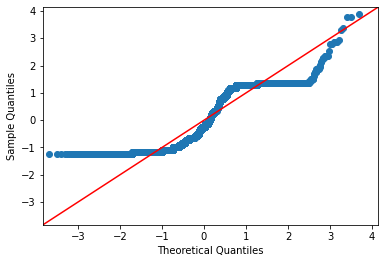

In [6457]:
# Test de normalité de la distribution du nombre de videos (Q-Q plot)
qqplot(data=mdl_video_vs_genre.resid, fit=True, line="45")
plt.show()

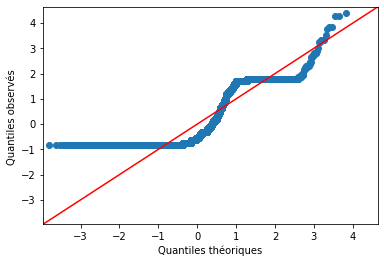

In [6458]:
#qqplot(data=etu_genre_video["video"], fit=True, line="45")
qqplot(data=total_video_etu["video"], fit=True, line="45")
plt.xlabel("Quantiles théoriques")
plt.ylabel("Quantiles observés ")
plt.savefig("../graph/distribution_video3.png")
plt.show()

In [6459]:
# Test de  Kolmogrov-Smirnov
stat, p = kstest(total_video_etu["video"], 'norm')

In [6460]:
stat, p

(0.5391101414598032, 0.0)

In [6461]:
# Test non paramétrique de Mann-Whitney U
mannwhitneyu(df_hom["video"], df_fem["video"])

MannwhitneyuResult(statistic=8200580.5, pvalue=0.0003907509304995919)

In [6462]:
# Nombre de quiz par étudiant
total_quiz_etu = total_quiz.groupby("Student_ID").sum()

In [6463]:
# Nombre de Quiz et vidéos par étudiants
video_quiz_etu = total_video_etu.merge(total_quiz_etu, on="Student_ID")

In [6464]:
# Test de Pearson
correlation, p_value = pearsonr(video_quiz_etu["quiz"], video_quiz_etu["video"])

In [6465]:
correlation, p_value

(0.8036026075037674, 0.0)

In [6466]:
# Test de Spearman
correlation, p_value = spearmanr(video_quiz_etu["quiz"], video_quiz_etu["video"])

In [6467]:
correlation, p_value

(0.804511796629543, 0.0)

Il y a une forte corrélation (0.8) entre le nombre de videos vues et le nombre de quiz réalisés par un étudiant. La corrélation observée est statistiquement significative (p-value=0).

In [6468]:
# Modèle de regression sur le nombre de vidéos selon le nombre de quiz
mdl_video_vs_quiz = ols("quiz ~ video", data=video_quiz_etu).fit()

In [6469]:
mdl_video_vs_quiz.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   quiz   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 2.653e+04
Date:                Tue, 27 Jun 2023   Prob (F-statistic):               0.00
Time:                        19:35:55   Log-Likelihood:                -24981.
No. Observations:               14557   AIC:                         4.997e+04
Df Residuals:                   14555   BIC:                         4.998e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5652      0.014     39.183      0.000       0.537       0.594
video          0.1575      0.001    162.896      0.000       0.156       0.159
==============================================================================
Omnibus:                     5315.454   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20116.783
Skew:                           1.821   Prob(JB):                         0.00
Kurtosis:                       7.461   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

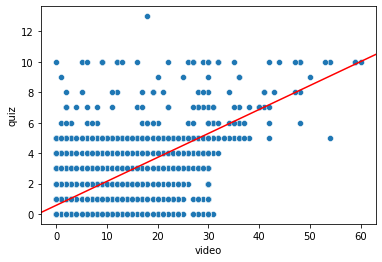

In [6470]:
intercept, coef = mdl_video_vs_quiz.params
sns.scatterplot(data=video_quiz_etu, x="video", y="quiz")
plt.axline(xy1=(0,intercept), slope=coef, color="red")
plt.savefig("../graph/scatter2_regression.png")
plt.show()

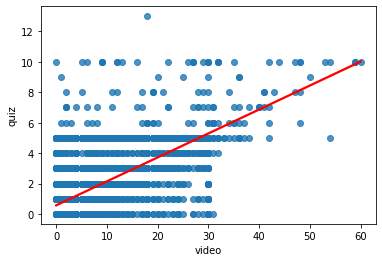

In [6471]:
fig, ax = plt.subplots()
sns.regplot(data=video_quiz_etu, x=video_quiz_etu["video"], y=video_quiz_etu["quiz"], line_kws={"color": "red"}, ax=ax)
#plt.savefig("../graph/scatter_regression.png")
plt.show()

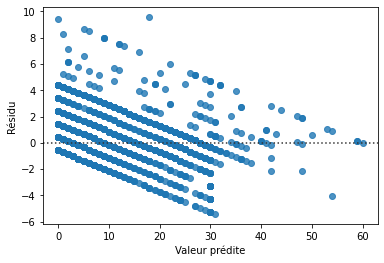

In [6472]:
# Résidus du modèle de prédiction
fig, ax = plt.subplots()
sns.residplot(data=video_quiz_etu, x="video", y="quiz", ax=ax)
#ax.set_title("Résidus du modèle observé")
ax.set_ylabel("Résidu")
ax.set_xlabel("Valeur prédite")
plt.savefig("../graph/residus_regression.png")
plt.show()

In [6473]:
# HDI des apprenants
student_hdi = base[["Student_ID", "New_HDI"]].dropna().set_index("Student_ID")
student_hdi.sort_values("Student_ID", inplace=True)

In [6474]:
student_hdi

,New_HDI
Student_ID,
45,TH
83,I
84,B
87,TH
94,TH
...,...
68282,B
68326,TH
68332,I


In [6475]:
# Tableau des 3 variables dont 2 catégorielles et 1 continue
video_genre_hdi = etu_genre_video.merge(student_hdi, on="Student_ID")

In [6476]:
video_genre_hdi

,Student_ID,video,Genre,New_HDI
0,45,25,Femme,TH
1,83,22,Homme,I
2,84,8,Homme,B
3,87,1,Homme,TH
4,94,2,Homme,TH
...,...,...,...,...
8860,68282,1,Homme,B
8861,68326,30,Femme,TH
8862,68332,4,Femme,I
8863,68365,0,Femme,TH


In [6477]:
# Modèle linéaire sans interaction(genre, HDI, video)
mdl1 = ols("video ~ C(Genre) + C(New_HDI)", data=video_genre_hdi).fit()

In [6478]:
mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  video   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     177.2
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          1.41e-111
Time:                        19:35:57   Log-Likelihood:                -34351.
No. Observations:                8865   AIC:                         6.871e+04
Df Residuals:                    8861   BIC:                         6.874e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             7.0011      0.432     16.211      0.000       6.155       7.848
C(Genre)[T.Homme]    -0.0959      0.267     -0.360      0.719      -0.618       0.427
C(New_HDI)[T.I]       4.6774      0.586      7.979      0.000       3.528       5.826
C(New_HDI)[T.TH]      8.6728      0.395     21.937      0.000       7.898       9.448
==============================================================================
Omnibus:                    11867.785   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              639.581
Skew:                           0.218   Prob(JB):                    1.31e-139
Kurtosis:                       1.759   Cond. No.                         8.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6479]:
# ANOVA sans interaction
anova_table = sm.stats.anova_lm(mdl1, typ=1)

In [6480]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),1.0,1.554895e+03,1554.895102,11.437356,7.229351e-04
C(New_HDI),2.0,7.071483e+04,35357.416782,260.078874,1.738249e-110
Residual,8861.0,1.204643e+06,135.948823,NaN,NaN


In [6481]:
# Modèle de regression avec interaction
mdl2 = ols("video ~ C(Genre)*C(New_HDI)", data=video_genre_hdi).fit()

In [6482]:
mdl2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  video   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     107.8
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          7.64e-111
Time:                        19:35:57   Log-Likelihood:                -34347.
No. Observations:                8865   AIC:                         6.871e+04
Df Residuals:                    8859   BIC:                         6.875e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              7.3310      0.968      7.573      0.000       5.434       9.229
C(Genre)[T.Homme]                     -0.4810      1.046     -0.460      0.646      -2.531       1.569
C(New_HDI)[T.I]                        2.7733      1.236      2.244      0.025       0.350       5.196
C(New_HDI)[T.TH]                       8.4673      0.995      8.506      0.000       6.516      10.419
C(Genre)[T.Homme]:C(New_HDI)[T.I]      2.8032      1.415      1.982      0.048       0.030       5.576
C(Genre)[T.Homme]:C(New_HDI)[T.TH]     0.1933      1.085      0.178      0.859      -1.933       2.320
==============================================================================
Omnibus:                    11724.976   Durbin-Watson:                   1.891
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              637.561
Skew:                           0.217   Prob(JB):                    3.59e-139
Kurtosis:                       1.760   Cond. No.                         33.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6483]:
# ANOVA avec interaction
anova_table = sm.stats.anova_lm(mdl2, typ=1)

In [6484]:
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Genre),1.0,1.554895e+03,1554.895102,11.443839,7.204212e-04
C(New_HDI),2.0,7.071483e+04,35357.416782,260.226287,1.514733e-110
C(Genre):C(New_HDI),2.0,9.541531e+02,477.076535,3.511225,2.990187e-02
Residual,8859.0,1.203688e+06,135.871810,NaN,NaN


In [6485]:
df_exam.rename(columns={"Exam.bin": "Exam", "Certif.bin": "Certif"}, inplace=True)
df_exam.reset_index(inplace=True)
df_exam.dropna(subset=["Gender", "New_HDI"], inplace=True)

In [6486]:
df_exam

,Itération,Student_ID,Gender,New_HDI,Exam,Certif,Assignment.bin
1,1,19178,une femme,TH,False,False,0
2,1,1086,une femme,TH,False,False,0
3,1,1948,une femme,TH,False,False,0
4,1,16209,une femme,B,False,False,0
8,1,402,une femme,B,False,False,1
...,...,...,...,...,...,...,...
15165,3,33473,une femme,TH,False,False,0
15167,3,64940,un homme,TH,False,False,0
15172,3,33848,un homme,TH,False,False,0
15176,3,24513,un homme,TH,False,False,0


In [6487]:
# Obtention de l'examen et/ou de la certification
df_exam["Exam_Certif"] = df_exam["Exam"] | df_exam["Certif"]
df_exam["Exam_Certif"] = df_exam["Exam_Certif"].astype(int)

In [6488]:
df_exam.set_index("Itération", inplace=True)

In [6489]:
# Obtention ou non par itération
df_exam_v1 = df_exam.loc[1]
df_exam_v2 = df_exam.loc[2]
df_exam_v3 = df_exam.loc[3]

In [6490]:
df_exam_v2

,Student_ID,Gender,New_HDI,Exam,Certif,Assignment.bin,Exam_Certif
Itération,,,,,,,
2,32360,une femme,TH,True,False,1,1
2,27808,un homme,B,True,False,1,1
2,27532,un homme,TH,True,False,1,1
2,2630,un homme,B,True,False,1,1
2,23971,un homme,TH,False,False,0,0
...,...,...,...,...,...,...,...
2,29275,une femme,TH,True,False,1,1
2,28828,un homme,I,True,False,1,1
2,26940,un homme,TH,True,False,1,1


In [6491]:
# Modèle logistic (GLM) de type binomial (variable dépendante binaire) appliqué pour chaque itération
formula = "Exam_Certif ~ Gender + New_HDI"
model = []
for n, version in enumerate([df_exam_v1, df_exam_v2, df_exam_v3]):
    model.append(glm(formula=formula, data=version, family=sm.families.Binomial()))

In [6492]:
# résultats de la fonction logistic par itération
result_v1 = model[0].fit()
result_v2 = model[1].fit()
result_v3 = model[2].fit()

In [6493]:
# Valeurs prédites pour chaque itérations
df_exam_v1["predicted"] = np.round(result_v1.predict(), decimals=0).astype(int)
df_exam_v2["predicted"] = np.round(result_v2.predict(), decimals=0).astype(int)
df_exam_v3["predicted"] = np.round(result_v3.predict(), decimals=0).astype(int)

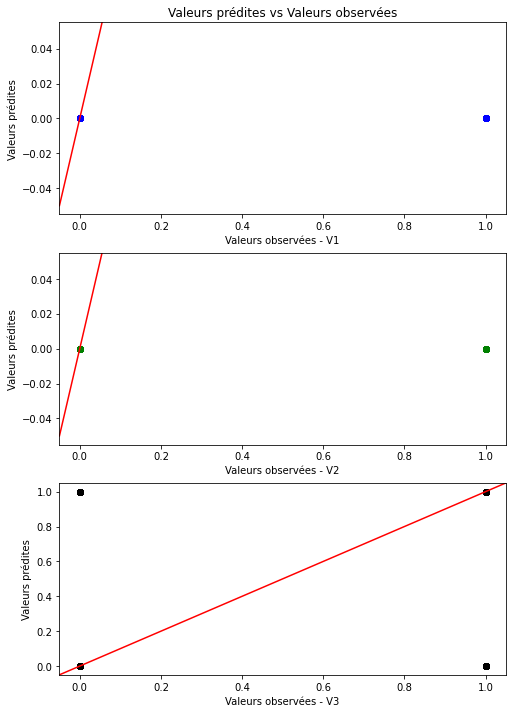

In [6494]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,12))
ax1.scatter(x=df_exam_v1["Exam_Certif"], y=df_exam_v1['predicted'], color="blue")
ax1.axline((0, 0), slope=1, color='red', linestyle='-')
ax1.set_xlabel('Valeurs observées - V1')
ax1.set_ylabel('Valeurs prédites')
ax1.set_title('Valeurs prédites vs Valeurs observées')

ax2.scatter(x=df_exam_v2["Exam_Certif"], y=df_exam_v2['predicted'], color="green")
ax2.axline((0, 0), slope=1, color='red', linestyle='-')
ax2.set_xlabel('Valeurs observées - V2')
ax2.set_ylabel('Valeurs prédites')

ax3.scatter(x=df_exam_v3["Exam_Certif"], y=df_exam_v3['predicted'], color="black")
ax3.axline((0, 0), slope=1, color='red', linestyle='-')
ax3.set_xlabel('Valeurs observées - V3')
ax3.set_ylabel('Valeurs prédites')

plt.show()

In [6495]:
result_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            Exam_Certif   No. Observations:                 5237
Model:                            GLM   Df Residuals:                     5233
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -128.64
Date:                Tue, 27 Jun 2023   Deviance:                       257.28
Time:                        19:35:58   Pearson chi2:                 4.84e+03
No. Iterations:                    25   Pseudo R-squ. (CS):           0.001021
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.9120      0.715     -8.266      0.000      -7.314      -4.510
Gender[T.une femme]     0.6235      0.456      1.367      0.172      -0.270       1.517
New_HDI[T.I]          -20.8950   1.75e+04     -0.001      0.999   -3.43e+04    3.42e+04
New_HDI[T.TH]           0.2241      0.756      0.297      0.767      -1.257       1.705
=======================================================================================
"""

In [6496]:
result_v1.params

Intercept              -5.912033
Gender[T.une femme]     0.623483
New_HDI[T.I]          -20.894989
New_HDI[T.TH]           0.224113
dtype: float64

In [6497]:
# Calcul des odds-ratio, p-value et ci pour chaque itération par rapport à l'intercept
mooc = ["V1", "V2", "V3"]
full_odds_r, full_pvalues, full_ci = [], [], []
for n, version in enumerate([result_v1, result_v2, result_v3]):
    # OR
    odds_r = np.exp(version.params).round(3)
    odds_r["Intercept"] = 1
    odds_r.name = mooc[n]
    full_odds_r.append(odds_r)
    # p-value
    p_values = version.pvalues.round(3)
    p_values.name = mooc[n]
    full_pvalues.append(p_values)
    # interval de confiance (ci)
    ci = np.exp(version.conf_int()) # intervalle à 95 %
    ci = "[" + ci[0].round(3).astype(str) + ", " + ci[1].round(3).astype(str) + "]"
    ci.name = mooc[n]
    full_ci.append(ci)

In [6498]:
tab_coef = pd.concat([pd.DataFrame(full_odds_r).T, pd.DataFrame(full_pvalues).T, pd.DataFrame(full_ci).T])

In [6499]:
index = pd.MultiIndex.from_arrays([["odds-ratio", "odds-ratio", "odds-ratio", "odds-ratio", 
                                    "p-value", "p-value", "p-value", "p-value", 
                                    "ci", "ci", "ci", "ci"], 
                                    tab_coef.index], names=["type", "coef"])

In [6500]:
tab_full = pd.DataFrame({"V1": list(tab_coef["V1"]), "V2": list(tab_coef["V2"]), "V3": list(tab_coef["V3"])}, index=index)

In [6501]:
tab_full.reset_index(inplace=True)

In [6502]:
tab_full.set_index(["type"], inplace=True)

In [6503]:
tab_full

,coef,V1,V2,V3
type,,,,
odds-ratio,Intercept,1.0,1.0,1.0
odds-ratio,Gender[T.une femme],1.865,1.021,0.813
odds-ratio,New_HDI[T.I],0.0,1.046,1.062
odds-ratio,New_HDI[T.TH],1.251,1.558,0.835
p-value,Intercept,0.0,0.0,0.157
p-value,Gender[T.une femme],0.172,0.826,0.053
p-value,New_HDI[T.I],0.999,0.849,0.813
p-value,New_HDI[T.TH],0.767,0.004,0.311
ci,Intercept,"[0.001, 0.011]","[0.329, 0.587]","[0.913, 1.762]"


p > 0.05 : Non significatif (pas d'astérisque)
0.01 < p ≤ 0.05 : * (un astérisque)
0.001 < p ≤ 0.01 : ** (deux astérisques)
p ≤ 0.001 : *** (trois astérisques)

In [6504]:
ci_v1 = tab_full.loc["ci", ["coef", "V1"]]
or_v1 = tab_full.loc["odds-ratio", ["coef", "V1"]]
pval_v1 = tab_full.loc["p-value", ["coef", "V1"]]

ci_v2 = tab_full.loc["ci", ["coef", "V2"]]
or_v2 = tab_full.loc["odds-ratio", ["coef", "V2"]]
pval_v2 = tab_full.loc["p-value", ["coef", "V2"]]

ci_v3 = tab_full.loc["ci", ["coef", "V3"]]
or_v3 = tab_full.loc["odds-ratio", ["coef", "V3"]]
pval_v3 = tab_full.loc["p-value", ["coef", "V3"]]

In [6505]:
ci_v1.rename(columns={'V1': 'CI'}, inplace=True)
ci_v2.rename(columns={'V2': 'CI'}, inplace=True)
ci_v3.rename(columns={'V3': 'CI'}, inplace=True)

or_v1.rename(columns={'V1': 'OR'}, inplace=True)
or_v2.rename(columns={'V2': 'OR'}, inplace=True)
or_v3.rename(columns={'V3': 'OR'}, inplace=True)

pval_v1.rename(columns={'V1': 'pval'}, inplace=True)
pval_v2.rename(columns={'V2': 'pval'}, inplace=True)
pval_v3.rename(columns={'V3': 'pval'}, inplace=True)

In [6506]:
# Extraction des bornes inférieure et supérieure des CI
ci_v1[["ll", "hl"]] = ci_v1["CI"].str.strip("[]").str.split(",", expand=True).astype(float)
ci_v2[["ll", "hl"]] = ci_v2["CI"].str.strip("[]").str.split(",", expand=True).astype(float)
ci_v3[["ll", "hl"]] = ci_v3["CI"].str.strip("[]").str.split(",", expand=True).astype(float)

In [6507]:
# Tableaux des valeurs pour créer le forestplot
forest_v1 = ci_v1.merge(or_v1, on="coef").merge(pval_v1, on="coef")
forest_v2 = ci_v2.merge(or_v2, on="coef").merge(pval_v2, on="coef")
forest_v3 = ci_v3.merge(or_v3, on="coef").merge(pval_v3, on="coef")

In [6508]:
# Renommage de l'intercept
forest_v1.iloc[0, 0] = "Réf (homme/HDI B)"
forest_v2.iloc[0, 0] = "Réf (homme/HDI B)"
forest_v3.iloc[0, 0] = "Réf (homme/HDI B)"

In [6509]:
# Mise à zero des intervalle de confiance de l'intercept
forest_v1.loc[0, "ll"] = 0 
forest_v1.loc[0, "hl"] = 0
forest_v2.loc[0, "ll"] = 0 
forest_v2.loc[0, "hl"] = 0
forest_v3.loc[0, "ll"] = 0 
forest_v3.loc[0, "hl"] = 0

In [6510]:
forest_v1

,coef,CI,ll,hl,OR,pval
0,Réf (homme/HDI B),"[0.001, 0.011]",0.000,0.000,1.0,0.0
1,Gender[T.une femme],"[0.763, 4.56]",0.763,4.560,1.865,0.172
2,New_HDI[T.I],"[0.0, inf]",0.000,inf,0.0,0.999
3,New_HDI[T.TH],"[0.284, 5.503]",0.284,5.503,1.251,0.767


In [6511]:
forest_v2

,coef,CI,ll,hl,OR,pval
0,Réf (homme/HDI B),"[0.329, 0.587]",0.000,0.000,1.0,0.0
1,Gender[T.une femme],"[0.851, 1.224]",0.851,1.224,1.021,0.826
2,New_HDI[T.I],"[0.66, 1.658]",0.660,1.658,1.046,0.849
3,New_HDI[T.TH],"[1.149, 2.113]",1.149,2.113,1.558,0.004


In [6512]:
forest_v3

,coef,CI,ll,hl,OR,pval
0,Réf (homme/HDI B),"[0.913, 1.762]",0.000,0.000,1.0,0.157
1,Gender[T.une femme],"[0.66, 1.003]",0.660,1.003,0.813,0.053
2,New_HDI[T.I],"[0.647, 1.741]",0.647,1.741,1.062,0.813
3,New_HDI[T.TH],"[0.589, 1.184]",0.589,1.184,0.835,0.311


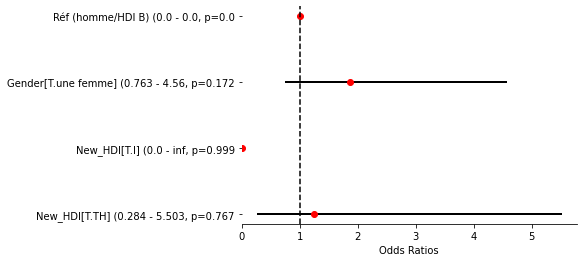

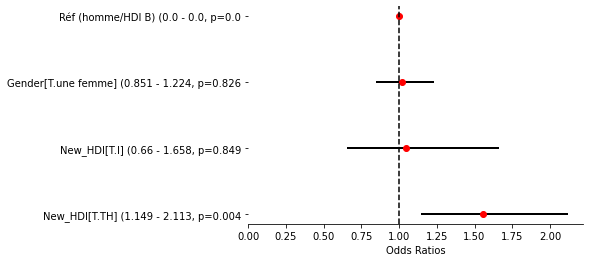

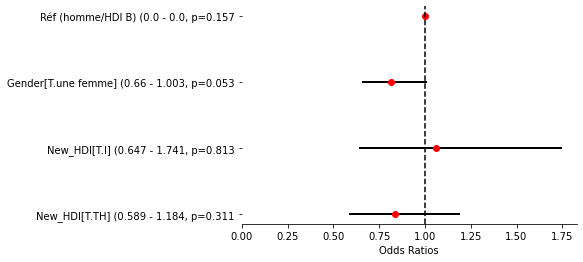

In [6513]:
for n, version in enumerate([forest_v1, forest_v2, forest_v3]):
    version = version[::-1]
    # Données de la régression logistique
    odds_ratios = version["OR"].tolist()
    ci = list(zip(version["ll"], version["hl"]))
    ci_inf = version["ll"].astype(str)
    ci_sup = version["hl"].astype(str)
    labels = version["coef"] + " (" + ci_inf + " - " + ci_sup + ", p=" + version["pval"].astype(str)
    
    # Création du forest plot
    fig, ax = plt.subplots()

    # OR, intervalles de confiance
    for i, (or_val, (ci_low, ci_high), label) in enumerate(zip(odds_ratios, ci, labels)):
        ax.plot([ci_low, ci_high], [i, i], color="black", linewidth=2)
        ax.plot(or_val, i, 'ro')

    # Réglages des axes
    ax.set_xlim(left=0)
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xlabel('Odds Ratios')
    ax.axvline(1, color='black', linestyle='--')
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    #file_name = "../graph/forestplot_V" + str(n) + "_binomiale.png"
    #plt.savefig(file_name)
    #plt.show()

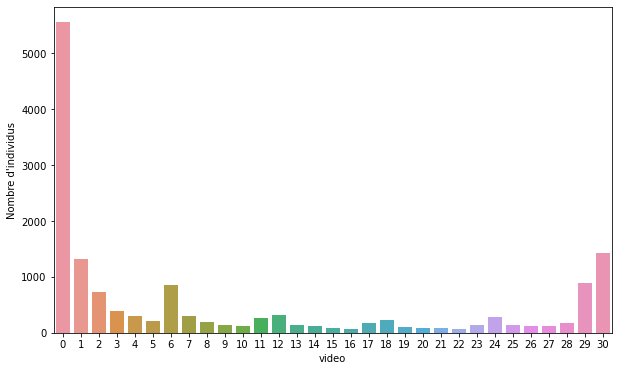

In [6514]:
# Distribution du nombre de videos pour l'ensemble des versions
video_graph = df_video.reset_index()
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(data=total_video, x="video", ax=ax)
plt.ylabel("Nombre d'individus")
plt.savefig("../graph/distribution_poisson.png")
plt.show()

In [6515]:
df_glm_video = total_video.reset_index(["Gender", "New_HDI"]).dropna()

In [6516]:
df_glm_video

Gender New_HDI  video
Itération Student_ID                          
1         19178       une femme      TH      1
          1086        une femme      TH     30
          1948        une femme      TH      1
          16209       une femme       B      0
          402         une femme       B     11
...                         ...     ...    ...
3         33473       une femme      TH      6
          64940        un homme      TH      0
          33848        un homme      TH     18
          24513        un homme      TH     18
          42092        un homme       B      2

[8951 rows x 3 columns]

In [6517]:
df_video_v1 = df_glm_video.loc[1]
df_video_v2 = df_glm_video.loc[2]
df_video_v3 = df_glm_video.loc[3]

In [6518]:
df_video_v1

,Gender,New_HDI,video
Student_ID,,,
19178,une femme,TH,1
1086,une femme,TH,30
1948,une femme,TH,1
16209,une femme,B,0
402,une femme,B,11
...,...,...,...
3528,un homme,B,0
14849,un homme,B,3
18143,un homme,I,1


In [6519]:
formula = "video ~ C(Gender) + C(New_HDI)"
# Regression de Poisson
model = []
for n, version in enumerate([df_video_v1, df_video_v2, df_video_v3]):
    model.append(glm(formula=formula, data=version, family=sm.families.Poisson()))

In [6520]:
# résultats de la fonction logistic par itération
result_v1 = model[0].fit()
result_v2 = model[1].fit()
result_v3 = model[2].fit()

In [6521]:
result_v3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  video   No. Observations:                 1560
Model:                            GLM   Df Residuals:                     1556
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11729.
Date:                Tue, 27 Jun 2023   Deviance:                       17520.
Time:                        19:36:00   Pearson chi2:                 1.44e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3706
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2.1441      0.029     75.004      0.000       2.088       2.200
C(Gender)[T.une femme]    -0.0484      0.013     -3.588      0.000      -0.075      -0.022
C(New_HDI)[T.I]            0.4085      0.039     10.518      0.000       0.332       0.485
C(New_HDI)[T.TH]           0.6808      0.029     23.080      0.000       0.623       0.739
==========================================================================================
"""

In [6522]:
# Valeurs prédites pour chaque itérations
df_video_v1["predicted"] = result_v1.predict()
df_video_v2["predicted"] = result_v2.predict()
df_video_v3["predicted"] = result_v3.predict()

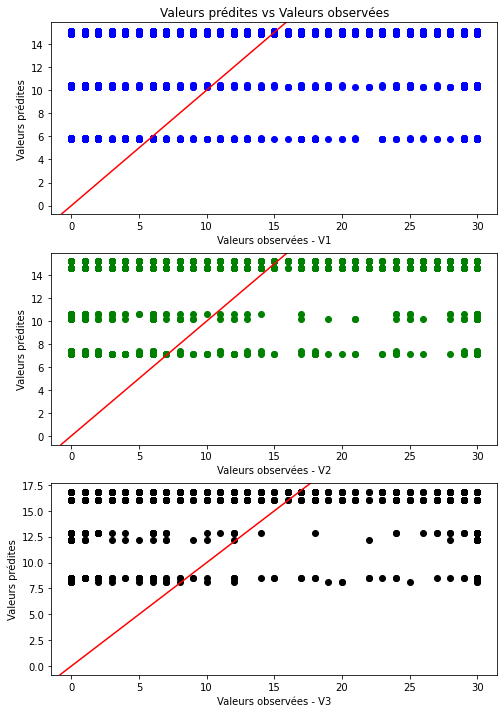

In [6523]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,12))
ax1.scatter(x=df_video_v1["video"], y=df_video_v1['predicted'], color="blue")
ax1.axline((0, 0), slope=1, color='red', linestyle='-')
ax1.set_xlabel('Valeurs observées - V1')
ax1.set_ylabel('Valeurs prédites')
ax1.set_title('Valeurs prédites vs Valeurs observées')

ax2.scatter(x=df_video_v2["video"], y=df_video_v2['predicted'], color="green")
ax2.axline((0, 0), slope=1, color='red', linestyle='-')
ax2.set_xlabel('Valeurs observées - V2')
ax2.set_ylabel('Valeurs prédites')

ax3.scatter(x=df_video_v3["video"], y=df_video_v3['predicted'], color="black")
ax3.axline((0, 0), slope=1, color='red', linestyle='-')
ax3.set_xlabel('Valeurs observées - V3')
ax3.set_ylabel('Valeurs prédites')

plt.show()

In [6524]:
# Calcul des odds-ratio, p-value et ci pour chaque itération
full_odds_r, full_pvalues, full_ci = [], [], []
for n, version in enumerate([result_v1, result_v2, result_v3]):
    # OR
    odds_r = np.exp(version.params).round(3)
    odds_r["Intercept"] = 1
    odds_r.name = mooc[n]
    full_odds_r.append(odds_r)
    # p-value
    p_values = version.pvalues.round(3)
    p_values.name = mooc[n]
    full_pvalues.append(p_values)
    # intervalles de confiance (ci)
    ci = np.exp(version.conf_int(alpha=0.05)) # intervalle à 95 %
    ci = "[" + ci[0].round(3).astype(str) + ", " + ci[1].round(3).astype(str) + "]"
    ci.name = mooc[n]
    full_ci.append(ci)

In [6525]:
tab_coef = pd.concat([pd.DataFrame(full_odds_r).T, pd.DataFrame(full_pvalues).T, pd.DataFrame(full_ci).T])

In [6526]:
tab_coef

,V1,V2,V3
Intercept,1.0,1.0,1.0
C(Gender)[T.une femme],1.018,1.039,0.953
C(New_HDI)[T.I],1.784,1.427,1.505
C(New_HDI)[T.TH],2.577,2.047,1.975
Intercept,0.0,0.0,0.0
C(Gender)[T.une femme],0.032,0.002,0.0
C(New_HDI)[T.I],0.0,0.0,0.0
C(New_HDI)[T.TH],0.0,0.0,0.0
Intercept,"[5.58, 5.945]","[6.806, 7.515]","[8.069, 9.026]"
C(Gender)[T.une femme],"[1.001, 1.034]","[1.015, 1.064]","[0.928, 0.978]"


In [6527]:
index = pd.MultiIndex.from_arrays([["odds-ratio", "odds-ratio", "odds-ratio", "odds-ratio", 
                                    "p-value", "p-value", "p-value", "p-value", 
                                    "ci", "ci", "ci", "ci"], 
                                    tab_coef.index], names=["type", "coef"])

In [6528]:
tab_full = pd.DataFrame({"V1": list(tab_coef["V1"]), "V2": list(tab_coef["V2"]), "V3": list(tab_coef["V3"])}, index=index)
tab_full.reset_index(inplace=True)
tab_full.set_index(["type"], inplace=True)

In [6529]:
tab_full

,coef,V1,V2,V3
type,,,,
odds-ratio,Intercept,1.0,1.0,1.0
odds-ratio,C(Gender)[T.une femme],1.018,1.039,0.953
odds-ratio,C(New_HDI)[T.I],1.784,1.427,1.505
odds-ratio,C(New_HDI)[T.TH],2.577,2.047,1.975
p-value,Intercept,0.0,0.0,0.0
p-value,C(Gender)[T.une femme],0.032,0.002,0.0
p-value,C(New_HDI)[T.I],0.0,0.0,0.0
p-value,C(New_HDI)[T.TH],0.0,0.0,0.0
ci,Intercept,"[5.58, 5.945]","[6.806, 7.515]","[8.069, 9.026]"


In [6530]:
ci_v1 = tab_full.loc["ci", ["coef", "V1"]]
or_v1 = tab_full.loc["odds-ratio", ["coef", "V1"]]
pval_v1 = tab_full.loc["p-value", ["coef", "V1"]]

ci_v2 = tab_full.loc["ci", ["coef", "V2"]]
or_v2 = tab_full.loc["odds-ratio", ["coef", "V2"]]
pval_v2 = tab_full.loc["p-value", ["coef", "V2"]]

ci_v3 = tab_full.loc["ci", ["coef", "V3"]]
or_v3 = tab_full.loc["odds-ratio", ["coef", "V3"]]
pval_v3 = tab_full.loc["p-value", ["coef", "V3"]]

In [6531]:
ci_v1.rename(columns={'V1': 'CI'}, inplace=True)
ci_v2.rename(columns={'V2': 'CI'}, inplace=True)
ci_v3.rename(columns={'V3': 'CI'}, inplace=True)

or_v1.rename(columns={'V1': 'OR'}, inplace=True)
or_v2.rename(columns={'V2': 'OR'}, inplace=True)
or_v3.rename(columns={'V3': 'OR'}, inplace=True)

pval_v1.rename(columns={'V1': 'pval'}, inplace=True)
pval_v2.rename(columns={'V2': 'pval'}, inplace=True)
pval_v3.rename(columns={'V3': 'pval'}, inplace=True)

In [6532]:
# Extraction des bornes inférieure et supérieure des CI
ci_v1[["ll", "hl"]] = ci_v1["CI"].str.strip("[]").str.split(",", expand=True).astype(float)
ci_v2[["ll", "hl"]] = ci_v2["CI"].str.strip("[]").str.split(",", expand=True).astype(float)
ci_v3[["ll", "hl"]] = ci_v3["CI"].str.strip("[]").str.split(",", expand=True).astype(float)

In [6533]:
# Tableaux des valeurs pour créer le forestplot
forest_v1 = ci_v1.merge(or_v1, on="coef").merge(pval_v1, on="coef")
forest_v2 = ci_v2.merge(or_v2, on="coef").merge(pval_v2, on="coef")
forest_v3 = ci_v3.merge(or_v3, on="coef").merge(pval_v3, on="coef")

In [6534]:
forest_v1

,coef,CI,ll,hl,OR,pval
0,Intercept,"[5.58, 5.945]",5.580,5.945,1.0,0.0
1,C(Gender)[T.une femme],"[1.001, 1.034]",1.001,1.034,1.018,0.032
2,C(New_HDI)[T.I],"[1.708, 1.864]",1.708,1.864,1.784,0.0
3,C(New_HDI)[T.TH],"[2.494, 2.663]",2.494,2.663,2.577,0.0


In [6535]:
forest_v2

,coef,CI,ll,hl,OR,pval
0,Intercept,"[6.806, 7.515]",6.806,7.515,1.0,0.0
1,C(Gender)[T.une femme],"[1.015, 1.064]",1.015,1.064,1.039,0.002
2,C(New_HDI)[T.I],"[1.328, 1.532]",1.328,1.532,1.427,0.0
3,C(New_HDI)[T.TH],"[1.945, 2.154]",1.945,2.154,2.047,0.0


In [6536]:
forest_v3

,coef,CI,ll,hl,OR,pval
0,Intercept,"[8.069, 9.026]",8.069,9.026,1.0,0.0
1,C(Gender)[T.une femme],"[0.928, 0.978]",0.928,0.978,0.953,0.0
2,C(New_HDI)[T.I],"[1.394, 1.624]",1.394,1.624,1.505,0.0
3,C(New_HDI)[T.TH],"[1.864, 2.093]",1.864,2.093,1.975,0.0


In [6537]:
# Renommage de l'intercept
forest_v1.iloc[0, 0] = "Réf (homme/HDI B)"
forest_v2.iloc[0, 0] = "Réf (homme/HDI B)"
forest_v3.iloc[0, 0] = "Réf (homme/HDI B)"

In [6538]:
# Mise à zero des intervalles de confiance de l'intercept
forest_v1.loc[0, "ll"] = 0 
forest_v1.loc[0, "hl"] = 0
forest_v2.loc[0, "ll"] = 0 
forest_v2.loc[0, "hl"] = 0
forest_v3.loc[0, "ll"] = 0 
forest_v3.loc[0, "hl"] = 0

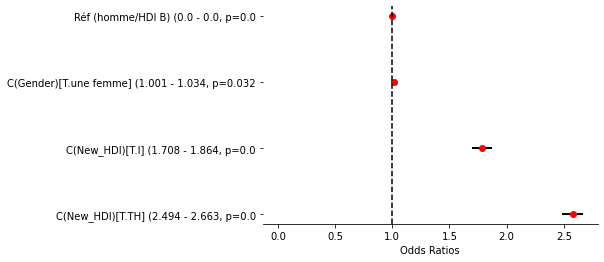

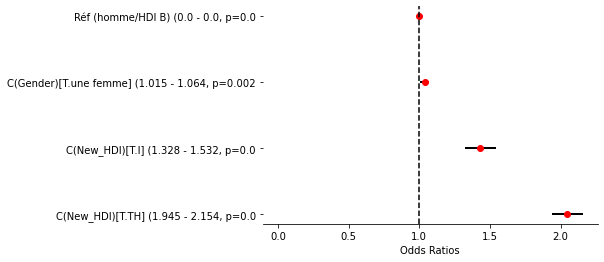

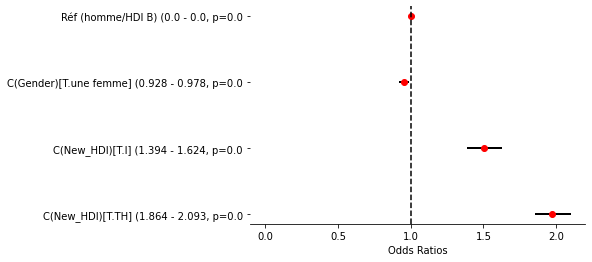

In [6539]:
for n, version in enumerate([forest_v1, forest_v2, forest_v3]):
    # Données de la régression logistique
    version = version[::-1]
    odds_ratios = version["OR"].tolist()
    ci = list(zip(version["ll"], version["hl"]))
    ci_inf = version["ll"].astype(str)
    ci_sup = version["hl"].astype(str)
    labels = version["coef"] + " (" + ci_inf + " - " + ci_sup + ", p=" + version["pval"].astype(str)
    
    # Création du forest plot
    fig, ax = plt.subplots()

    # OR, intervalles de confiance
    for i, (or_val, (ci_low, ci_high), label) in enumerate(zip(odds_ratios, ci, labels)):
        ax.plot([ci_low, ci_high], [i, i], color="black", linewidth=2)
        ax.plot(or_val, i, 'ro')

    # Réglages des axes
    ax.set_xlim()
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_xlabel('Odds Ratios')
    ax.axvline(1, color='black', linestyle='--')
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    #plt.title()
    file_name = "../graph/forestplot_V" + str(n) + "_poisson.png"
    #plt.savefig(file_name)
    plt.show()

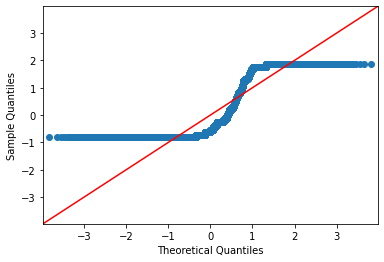

In [6541]:
# Test de normalité de la distribution du nombre de videos (Q-Q plot)
qqplot(data=total_video["video"], fit=True, line="45")
plt.savefig("../graph/distribution_video4.png")
plt.show()